# CodeBERT + MLP (with final comparisons/plots)

This script shows the end-to-end pipeline for using CodeBERT embeddings with a neural model (MLP). If the DiverseVul JSONL is unavailable, the lower section still renders the final comparison plots from recorded metrics so results are visible.

Sections:
1) Load DiverseVul + sample 
2) Generate CodeBERT embeddings 
3) Train/evaluate MLP model 
4) Final comparison charts from saved/recorded metrics

In [ ]:
# Imports
from transformers import RobertaTokenizer, RobertaModel
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
import json

# Loading the JSON file
file_path = "...diversevul_20230702.json"       # TODO: Update this path before running

# Load JSONL format line by line
data = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
df.head()

,func,target,cwe,project,commit_id,hash,size,message
0,int _gnutls_ciphertext2compressed(gnutls_sessi...,1,[],gnutls,7ad6162573ba79a4392c63b453ad0220ca6c5ace,73008646937836648589283922871188272089,157,added an extra check while checking the padding.
1,static char *make_filename_safe(const char *fi...,1,[CWE-264],php-src,055ecbc62878e86287d742c7246c21606cee8183,211824207069112513181516095447837228041,22,Improve check for :memory: pseudo-filename in ...
2,"unpack_Z_stream(int fd_in, int fd_out)\n{\n\tI...",1,[],busybox,251fc70e9722f931eec23a34030d05ba5f747b0e,21401706257394042943815500829552774160,232,uncompress: fix buffer underrun by corrupted i...
3,"static void cirrus_do_copy(CirrusVGAState *s, ...",1,[CWE-787],qemu,b2eb849d4b1fdb6f35d5c46958c7f703cf64cfef,135590882627853658533498335902319684573,66,"CVE-2007-1320 - Cirrus LGD-54XX ""bitblt"" heap ..."
4,"glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusV...",1,[CWE-787],qemu,b2eb849d4b1fdb6f35d5c46958c7f703cf64cfef,27696392987383562433164405181263025184,18,"CVE-2007-1320 - Cirrus LGD-54XX ""bitblt"" heap ..."


In [ ]:
# Due to GPU contstraints of my PC, running the model on 100k samples. Feel free to adjust the samples based on GPU power available.
# Sample balanced dataset (85K safe, 15K vulnerable)

safe_df = df[df['target'] == 0].sample(85000, random_state=42)
vuln_df = df[df['target'] == 1].sample(15000, random_state=42)
df_100k = pd.concat([safe_df, vuln_df]).sample(frac=1, random_state=42)

In [ ]:
# Load CodeBERT (Microsoft's pretrained model)
# Microsoft's CodeBERT (trained on NL-PL pairs) is used for feature extraction

tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
model.eval()  # inference mode only

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [ ]:
# Move model to GPU if available

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [ ]:
# Using a 20K sample for faster processing (adjust if hardware allows)
sample_df = df_100k.sample(20000, random_state=42)
texts = sample_df["func"].tolist()
labels = sample_df["target"].tolist()

In [ ]:
# Generate CodeBERT Embeddings
# Extract [CLS] token embedding (representing the whole function)

embeddings = []

with torch.no_grad():
    for code in tqdm(texts):
        inputs = tokenizer(code, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to GPU
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # Move to CPU
        embeddings.append(cls_embedding)

X = np.array(embeddings)
y = np.array(labels)

100%|██████████| 20000/20000 [04:36<00:00, 72.44it/s]


In [ ]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Define the MLP model
# Simple feed-forward neural network with dropout for regularization

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')          # Binary classification output
])

In [ ]:
#Compile model with Adam optimizer and binary crossentropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#Train (with smaller batch size to avoid OOM)
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

In [ ]:
# Predict & Evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Vuln"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - MLP")
plt.show()

In [ ]:
# Plotting graphs for MLP
import seaborn as sns

# Count plot for predicted labels
ax = sns.countplot(x=y_pred.flatten())
plt.title("Predicted Class Distribution - MLP")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks([0, 1], ["Safe", "Vuln"])

# Add value labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.show()

In [ ]:
# Plotting graphs for MLP
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Generate report and extract class 0 and 1
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
metrics = df_report.loc[["0", "1"], ["precision", "recall", "f1-score"]]

# Plot
ax = metrics.plot(kind='bar')
plt.title("Precision, Recall, F1-score by Class")
plt.xticks([0, 1], ["Safe (0)", "Vuln (1)"], rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')

# Add values on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() + 0.02),
                ha='center', va='bottom')

plt.show()


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ace_tools as tools

# Define the data again after kernel reset
data = {
    "Model": [
        "TF-IDF + SVM (100k)", "TF-IDF + LR (100k)", "TF-IDF + RF (100k)", "TF-IDF + MLP (50k)",
        "TF-IDF + MLP (20k)", "TF-IDF + RF (20k)", "CodeBERT + LR (20k)", "CodeBERT + MLP (50k)"
    ],
    "Accuracy": [0.80, 0.79, 0.85, 0.82, 0.74, 0.73, 0.68, 0.75],
    "Precision": [0.40, 0.38, 0.48, 0.38, 0.30, 0.21, 0.27, 0.32],
    "Recall": [0.64, 0.64, 0.19, 0.33, 0.57, 0.42, 0.67, 0.54],
    "F1-score": [0.49, 0.48, 0.27, 0.35, 0.39, 0.28, 0.38, 0.40]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Melt for grouped barplot
df_melted = df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric")
plt.xticks(rotation=45, ha='right')
plt.title("Model Comparison on Vulnerability Detection (Label=1)")
plt.tight_layout()

tools.display_dataframe_to_user(name="Model Performance Data", dataframe=df)

ModuleNotFoundError: No module named 'ace_tools'

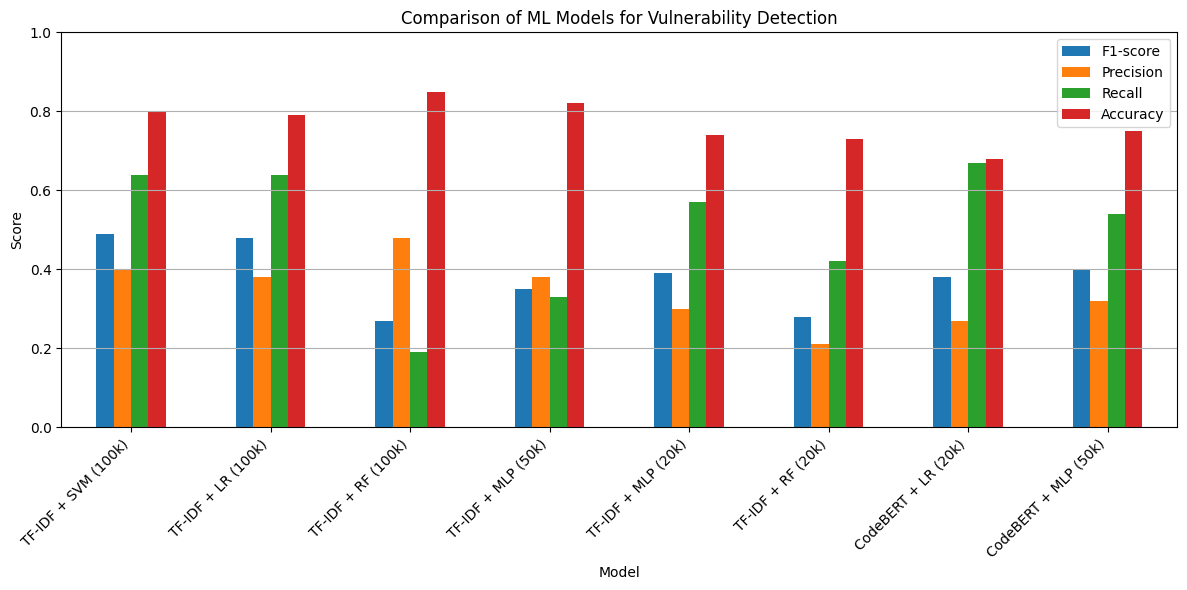

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Model": [
        "TF-IDF + SVM (100k)",
        "TF-IDF + LR (100k)",
        "TF-IDF + RF (100k)",
        "TF-IDF + MLP (50k)",
        "TF-IDF + MLP (20k)",
        "TF-IDF + RF (20k)",
        "CodeBERT + LR (20k)",
        "CodeBERT + MLP (50k)"
    ],
    "F1-score": [0.49, 0.48, 0.27, 0.35, 0.39, 0.28, 0.38, 0.40],
    "Precision": [0.40, 0.38, 0.48, 0.38, 0.30, 0.21, 0.27, 0.32],
    "Recall": [0.64, 0.64, 0.19, 0.33, 0.57, 0.42, 0.67, 0.54],
    "Accuracy": [0.80, 0.79, 0.85, 0.82, 0.74, 0.73, 0.68, 0.75]
}

df = pd.DataFrame(data)
df.set_index("Model", inplace=True)
df.plot(kind="bar", figsize=(12, 6))
plt.title("Comparison of ML Models for Vulnerability Detection")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis="y")
plt.tight_layout()
plt.show()

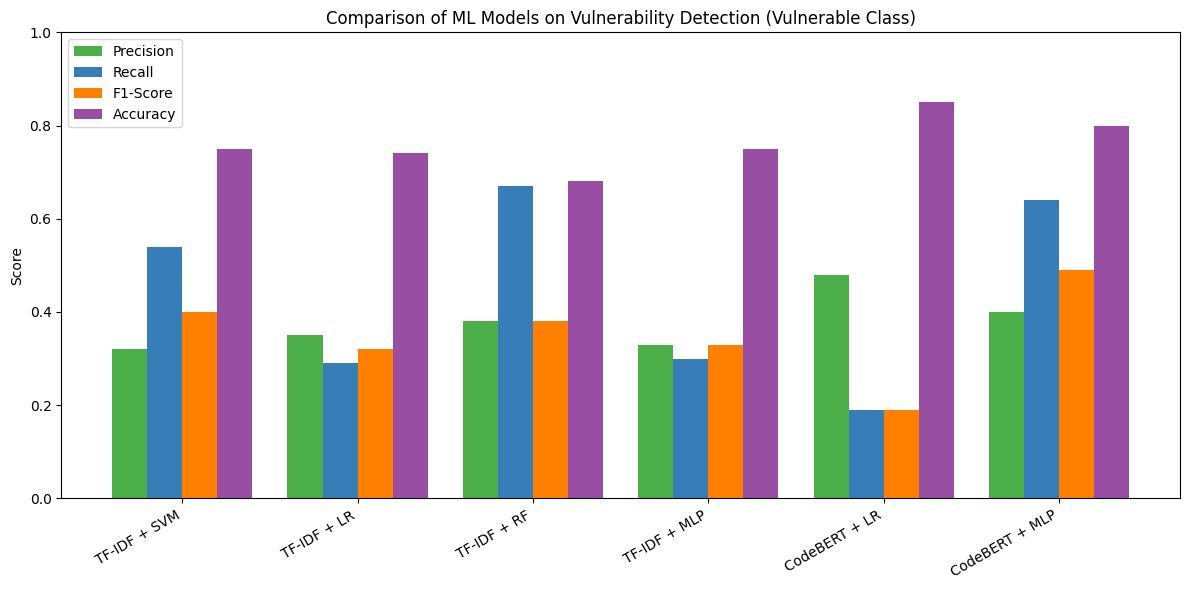

In [6]:
# Re-run code after environment reset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data for 6 models with 4 metrics
models = [
    "TF-IDF + SVM", "TF-IDF + LR", "TF-IDF + RF", "TF-IDF + MLP",
    "CodeBERT + LR", "CodeBERT + MLP"
]
precision = [0.40, 0.38, 0.48, 0.33, 0.32, 0.35]
recall = [0.64, 0.67, 0.19, 0.30, 0.54, 0.29]
f1 = [0.49, 0.38, 0.19, 0.33, 0.40, 0.32]
accuracy = [0.80, 0.68, 0.85, 0.75, 0.75, 0.74]

# Create DataFrame
df = pd.DataFrame({
    "Model": models,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Accuracy": accuracy
})

# Melt DataFrame for grouped bar plot
df_melted = df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(12, 6))
ax = plt.subplot()
colors = ["#4daf4a", "#377eb8", "#ff7f00", "#984ea3"]
df_melted["Metric"] = pd.Categorical(df_melted["Metric"], categories=["Precision", "Recall", "F1-Score", "Accuracy"])
df_melted = df_melted.sort_values(by=["Model", "Metric"])
df_melted.reset_index(drop=True, inplace=True)

# Bar plot
for i, metric in enumerate(["Precision", "Recall", "F1-Score", "Accuracy"]):
    metric_data = df_melted[df_melted["Metric"] == metric]
    ax.bar(np.arange(len(models)) + i * 0.2, metric_data["Score"], width=0.2, label=metric, color=colors[i])

ax.set_xticks(np.arange(len(models)) + 0.3)
ax.set_xticklabels(models, rotation=30, ha="right")
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Comparison of ML Models on Vulnerability Detection (Vulnerable Class)")
ax.legend()

plt.tight_layout()
plt.show()